In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
import matplotlib.pyplot as plt
import warnings

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
warnings.filterwarnings("ignore")

print(tf.__version__)

2.10.0


2700/2700 [==============================] - 4s 883us/step


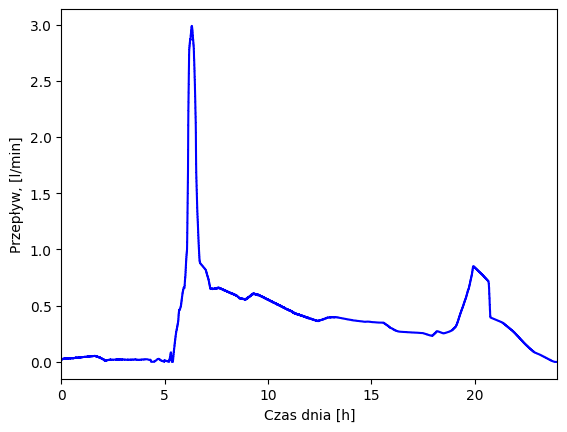

In [2]:
model= tf.keras.models.load_model("../Modele/11_12_testowanie/model_calosc_z_dodatku")
flow_time=np.arange(0,1,1/1440/60) 
flow_time_plot=np.arange(0,24,24/1440/60) 

test=0.9 #0.2 0.4 0.5 0.9gut 
model_input=np.vstack((2*np.ones_like(flow_time, dtype=int), 2*np.ones_like(flow_time, dtype=int), flow_time, test*np.ones_like(flow_time, dtype=int))).T

model_result=model.predict(model_input)
model_result=np.clip(model_result, a_min=0, a_max=None)
plt.plot(flow_time_plot, model_result,color='blue')

plt.xlabel('Czas dnia [h]')
plt.ylabel('Przepływ, [l/min]')
plt.xlim(0, 24)

F_in=model_result

F_in=F_in/3


In [3]:
T_set=50 #temperatura zadana
delta_t=4 #czułość
temp_in=15 # temperatura wody wejściowej
TEMP_OUT=19

B_1_2 = 0.3        # współczyniki wymiany ciepła miedzy 1 a 2 warstwą
B_1_IN =0.3        # współczyniki wymiany ciepła miedzy 1 a 0 warstwą
B_1_OUT=0.05         # współczyniki wymiany ciepła miedzy 1 a otoczeniem

B_2_3   =0.3        # współczyniki wymiany ciepła miedzy 2 a 3 warstwą
B_2_OUT =0.06        # współczyniki wymiany ciepła miedzy 2 a otoczeniem
B_2_HEAT=0.3       # współczyniki wymiany ciepła miedzy 2 a grzałką

B_3_OUT=0.06          # współczyniki wymiany ciepła miedzy 3 a otoczeniem
B_3_HEA=0.3           # współczyniki wymiany ciepła miedzy 3 a grzałką

MOC_PIECA=60        # moc pieca

P_piec  =0.3         # współczyniki działania pieca
P_OUT   =0.3        # współczyniki wymiany ciepła miedzy piecem a otoczeniem
P_3     =0.3        # współczyniki wymiany ciepła miedzy piecem a 3
F_Z     =0.3 

TWO_1_SET=30 # temepratura początkowa wody w 1 warstwie
TWO_2_SET=35 # temepratura początkowa wody w 2 warstwie
TWO_3_SET=T_set # temepratura początkowa wody w 3 warstwie
TZI_SET=40  # temepratura początkowa wody w piecu warstwie
Two_1 = np.array([TWO_1_SET])
Two_2 = np.array([TWO_2_SET])
Two_3 = np.array([TWO_3_SET])
Tzi = np.array([TZI_SET])
piec_ster = np.array([1])

In [4]:
for i in range(0, len(flow_time_plot)-1):
    Two_1=np.append(Two_1,Two_1[i]+
                    -B_1_IN*F_in[i]*(Two_1[i]-temp_in)         # 1 - 0
                     -B_1_OUT*(Two_1[i]-TEMP_OUT)                # 1 - OT
                     +B_1_2*(Two_2[i]-Two_1[i])                # 1 - 2
                     )               

    Two_2=np.append(Two_2,Two_2[i]+
                    -B_1_2*F_in[i]*(Two_2[i]-Two_1[i])       # 1 - 2
                     -B_2_OUT*(Two_2[i]-TEMP_OUT)                 # 2 - OT
                     +B_2_3*(Two_3[i]-Two_2[i])                 # 2 - 3 
                     +B_2_HEAT*F_Z*(Tzi[i]-Two_2[i])            # 2 - piec
                     )                 

    Two_3=np.append(Two_3,Two_3[i]+
                     -B_3_OUT*(Two_3[i]-TEMP_OUT)                 # 2 - OT
                     -B_2_3*(Two_3[i]-Two_2[i])                 # 3 - 2
                     +B_2_HEAT*F_Z*(Tzi[i]-Two_3[i])            # 3 - piec
                     ) 
    
    Tzi=np.append(Tzi,Tzi[i]+
                  piec_ster[i]*P_piec*MOC_PIECA                   # Piec
                  -P_3*F_Z*(Tzi[i]-Two_3[i])                    # piec - 3
                  -P_OUT*(Tzi[i]-TEMP_OUT))                       # piec - OT

    if(piec_ster[i]==1 and Two_2[i]>(T_set+delta_t)):
        piec_ster=np.append(piec_ster,0)
    elif (piec_ster[i]==0 and Two_2[i]<(T_set-delta_t)):
        piec_ster=np.append(piec_ster,1)
    else:
        piec_ster=np.append(piec_ster,piec_ster[i])

Text(0.5, 0, 'Czas, h')

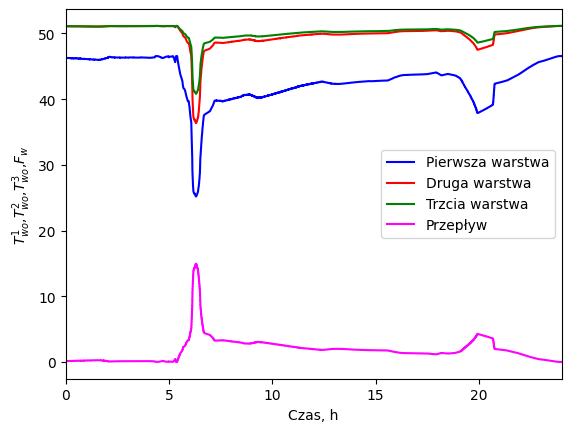

In [10]:
plt.plot(flow_time_plot, Two_1,color='blue', label='Pierwsza warstwa')
plt.plot(flow_time_plot, Two_2,color='red', label='Druga warstwa')
plt.plot(flow_time_plot, Two_3,color='green', label='Trzcia warstwa')
plt.plot(flow_time_plot, 5*model_result,color='magenta', label='Przepływ')
plt.xlim(0,24)
plt.legend()
plt.ylabel('$T_{wo}^1$,$T_{wo}^2$,$T_{wo}^3$,$F_w$')
plt.xlabel('Czas, h')

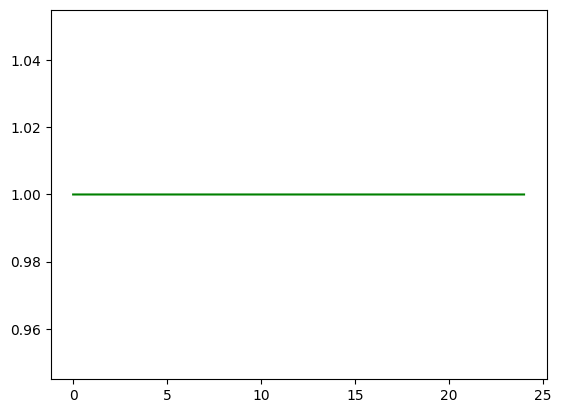

In [6]:
plt.plot(flow_time_plot, piec_ster,color='green')

## OPTYMALIZACJA

In [14]:
G=np.trapz(piec_ster*P_piec*MOC_PIECA)
G

1555182.0

In [16]:
sign = (np.sign(Two_3 - T_set - delta_t) + np.sign(Two_3 - T_set + delta_t)) / 2
temp_diff = (Two_3 - T_set) ** 2
J = np.trapz(temp_diff * np.abs(sign))
J

100222.2841038121